In [84]:
import numpy as np
import pandas as pd
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sea
%config InlineBackend.figure_format = 'retina'

In [197]:
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/871'
fbs_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_LOS-5M-USRP1'
cso_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_sigOver_5ms'
jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/0208_anomaly'

In [228]:
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/campus_drive'
fbs_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/campus_drive_LOS-5M-USRP1'
cso_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/campus_drive_sigOver_10ms'
jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/0208_anomaly'

In [217]:
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_ab_train'
fbs_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-USRP1'
cso_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver'
jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/0208_anomaly'

In [229]:
def rss_autocorr(path, step=1000):
    all_corrs = []
    if '0208_anomaly' in path:
        filenames = glob.glob(path + '/*.txt')
    else:
        filenames = glob.glob(path + '/*.txt')
    for file in filenames:
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        if np.shape(rss)[0] > 156000:
            rss = np.array(rss).reshape(-1)[:156000]
        elif np.shape(rss)[0] > 31000:
            rss = np.array(rss).reshape(-1)[:31000]
        else:
            break
        corrs = []
#         print(np.shape(rss))
        for i in range(step, len(rss), step):
            corr = pearsonr(rss[i - step:i], rss[i:i + step])[0]
            corrs.append(corr)
        all_corrs.extend(corrs)
    return all_corrs


def rss_mean(path, step=1000):
    all_means = []
    if '0208_anomaly' in path:
        filenames = glob.glob(path + '/*.txt')
    else:
        filenames = glob.glob(path + '/*.txt')
    for file in filenames:
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        if np.shape(rss)[0] > 156000:
            rss = np.array(rss).reshape(-1)[:156000]
        elif np.shape(rss)[0] > 31000:
            rss = np.array(rss).reshape(-1)[:31000]
        else:
            break
        means = []
        for i in range(step, len(rss), step):
            mean = np.mean(rss[i - 1000:i])
            means.append(mean)
        all_means.extend(means)
    return all_means

In [119]:
jamming_corrs = rss_autocorr(jamming_path, step=1000)

In [230]:
normal_corrs = rss_autocorr(normal_path, step=1000)
fbs_corrs = rss_autocorr(fbs_path, step=1000)
cso_corrs = rss_autocorr(cso_path, step=1000)
jamming_corrs = rss_autocorr(jamming_path, step=1000)

normal_means = rss_mean(normal_path, step=1000)
fbs_means = rss_mean(fbs_path, step=1000)
cso_means = rss_mean(cso_path, step=1000)
jamming_means = rss_mean(jamming_path, step=1000)

In [231]:
X = np.concatenate((normal_means, jamming_means, fbs_means, cso_means))
X_corrs = np.concatenate((normal_corrs, jamming_corrs , fbs_corrs, cso_corrs))
y = np.concatenate((['Normal']*np.shape(normal_means)[0], ['Jamming']*np.shape(jamming_means)[0], 
                    ['FBS']*np.shape(fbs_means)[0], ['CSO']*np.shape(cso_means)[0]))

In [192]:
X = np.concatenate((normal_means[:1200], jamming_means[:1200], fbs_means[:1200], cso_means[:1200]))
X_corrs = np.concatenate((normal_corrs[:1200], jamming_corrs[:1200] , fbs_corrs[:1200], cso_corrs[:1200]))
y = np.concatenate((['Normal']*np.shape(normal_means[:1200])[0], ['Jamming']*np.shape(jamming_means[:1200])[0], 
                    ['FBS']*np.shape(fbs_means[:1200])[0], ['CSO']*np.shape(cso_means[:1200])[0]))

In [232]:
print(np.shape(X), np.shape(X_corrs), np.shape(y))

(6990,) (6990,) (6990,)


In [233]:
df_rss_corr = pd.DataFrame(X, columns=['RSS'])
df_rss_corr['corr'] = X_corrs
df_rss_corr['Type'] = y

In [234]:
df_rss_corr

,RSS,corr,Type
0,-35.331874,-0.085561,Normal
1,-35.637764,-0.000589,Normal
2,-35.719803,0.020524,Normal
3,-35.592344,0.005914,Normal
4,-34.806810,0.068523,Normal
...,...,...,...
6985,-39.859206,0.039949,CSO
6986,-39.416214,-0.022851,CSO
6987,-39.453590,-0.032715,CSO
6988,-39.847154,-0.008737,CSO


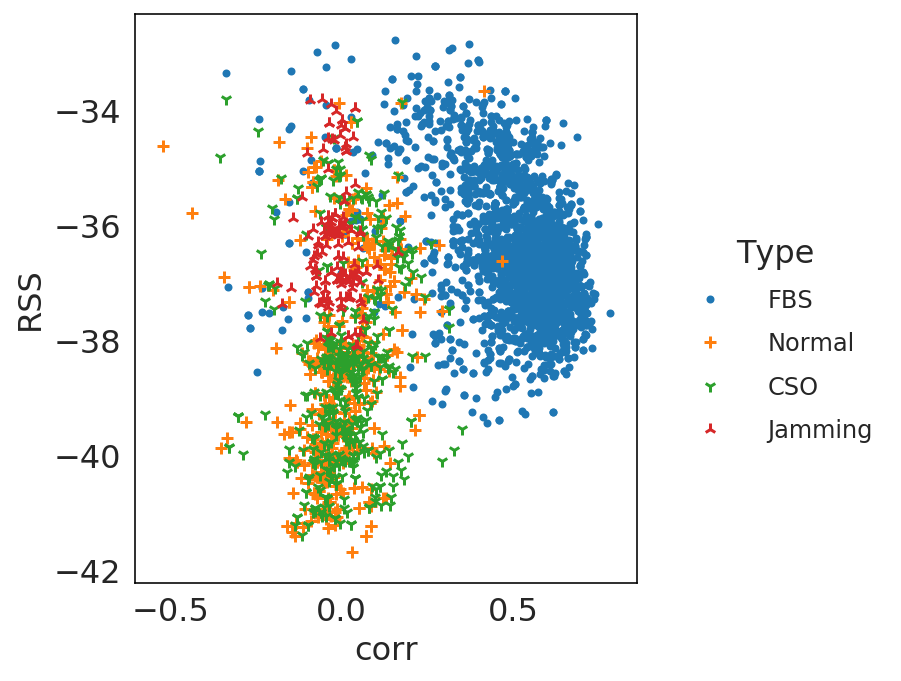

In [238]:
import seaborn as sns
df_sample = df_rss_corr.sample(frac=0.5, replace=True, random_state=1)
markers=['.', '+', '1', '2']
sns.set_style("white", {'axes.linewidth': 5, 'axes.edgecolor':'black'})
g = sns.lmplot(x='corr', y='RSS', markers = markers, 
           data=df_sample, hue='Type', fit_reg=False, scatter_kws={'alpha':1})
sns.despine(top=False, right=False)
plt.setp(g._legend.get_texts(), fontsize=12)
plt.show()

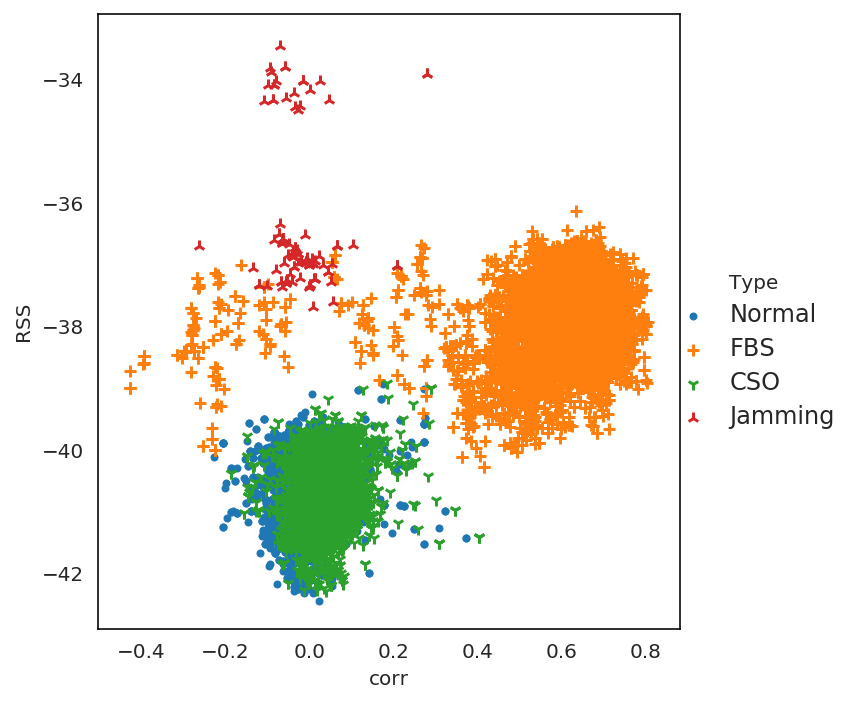

In [51]:
import seaborn as sns
df_sample = df_rss_corr.sample(frac=1, replace=True, random_state=1)
markers=['.', '+', '1', '2']
sns.set_style("white", {'axes.linewidth': 5, 'axes.edgecolor':'black'})
g = sns.lmplot(x='corr', y='RSS', markers = markers, 
           data=df_sample, hue='Type', fit_reg=False, scatter_kws={'alpha':1})
sns.despine(top=False, right=False)
plt.setp(g._legend.get_texts(), fontsize=12)
plt.show()

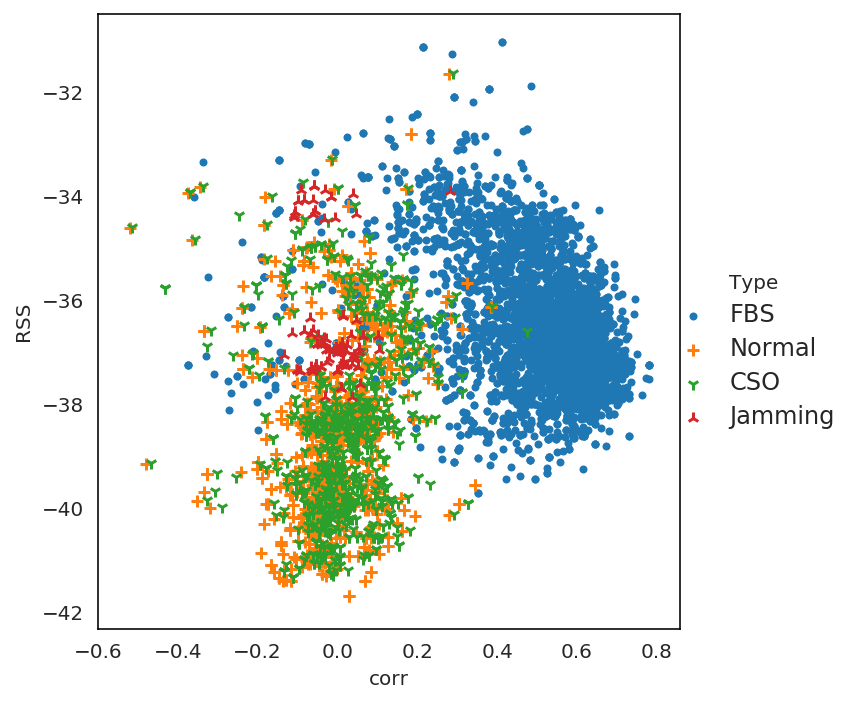

In [37]:
import seaborn as sns
df_sample = df_rss_corr.sample(frac=1, replace=True, random_state=1)
markers=['.', '+', '1', '2']
sns.set_style("white", {'axes.linewidth': 5, 'axes.edgecolor':'black'})
g = sns.lmplot(x='corr', y='RSS', markers = markers, 
           data=df_sample, hue='Type', fit_reg=False, scatter_kws={'alpha':1})
sns.despine(top=False, right=False)
plt.setp(g._legend.get_texts(), fontsize=12)
plt.show()

In [59]:
th = np.quantile(np.array(normal_corrs), 0.95)

In [60]:
x = np.where(np.array(fbs_corrs) > th, 1, 0)

In [61]:
sum(x) / len(x)

0.022473118279569892

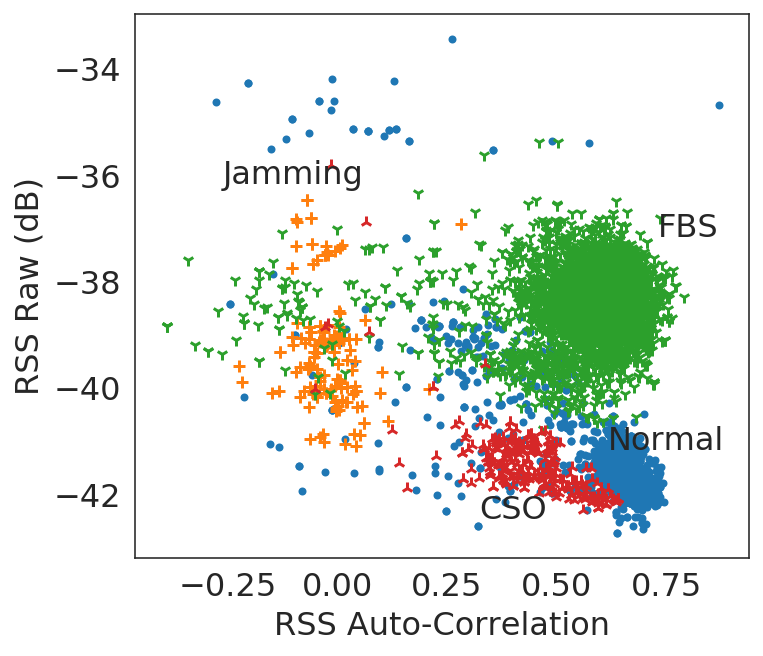

In [186]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)
plt.rcParams["figure.figsize"] = (5.5,5)
#set style of plots
sns.set_style('white')

#define a custom palette
# customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
# sns.set_palette(customPalette)
# sns.palplot(customPalette)
customMarker = ['.', '+', '1', '2']
#number of points per group
n = 1200

#define group labels and their centers
groups = {'Normal': (2,2),
          'Jamming': (3,4),
          'FBS': (4,4),
          'CSO': (4,1)}

#define labels and where they should go
labels = {'Normal': (0.75,-41),
          'Jamming': (-0.1,-36),
          'FBS': (0.8,-37),
          'CSO': (0.4,-42.3)}

#create labeled x and y data
data = df_sample
    
#create a new figure
plt.figure(figsize=(5.5,5))

#loop through labels and plot each cluster
for i, label in enumerate(groups.keys()):

    #add data points 
    plt.scatter(x=data.loc[data['Type']==label, 'corr'], 
                y=data.loc[data['Type']==label, 'RSS'], 
#                 color=customPalette[i],
                marker=customMarker[i],
                alpha=1)
    
    #add label
    plt.annotate(label, 
                 labels[label],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=16)
#                  size=16,
#                  color=customPalette[i]) 
plt.xlabel("RSS Auto-Correlation")
plt.ylabel("RSS Raw (dB)")
# plt.show()
plt.savefig('stable_rss.eps', bbox_inches = 'tight', format='eps')